
# Unsupervised Learning: Association Rules

Maintainer: Zhaohu(Jonathan) Fan. Contact him at (psujohnny@gmail.com)

Note: This lab note is still WIP, let us know if you encounter bugs or issues.

## Table of Contents

1. [Association Rules](#scrollTo=1-association-rules)  
   1.1 [Groceries Case](#scrollTo=11-groceries-case)  
   1.1.1 [Rule Identification](#scrollTo=111-rule-identification)  
   1.1.2 [Rule Visualization](#scrollTo=112-rule-visualization)  

2. [Case Starter Code](#scrollTo=2-case-starter-code)

#### *Colab Notebook [Open in Colab](https://colab.research.google.com/drive/10jWHwl-isGKBkLBQxVsV72_rWN6Gmbln?usp=sharing)*
#### *Useful information about [ Unsupervised Learning: Association Rules in R](https://yanyudm.github.io/Data-Mining-R/lecture/11_AssociationRules.html)*





## 1. Association Rules
<a id="1-association-rules"></a>

Association rules are a popular and well-researched method for discovering interesting relationships among itemsets in large databases. We begin by defining a few common measures of association.

**1. Support:** The support, $\text{supp}(X)$, measures how frequently an itemset \(X\) appears in the data. It is calculated as the proportion of transactions in the dataset that contain \(X\).

- Using Table 11 as an example, the support of \(\{apple\}\) is \(4\) out of \(8\), or **50%**. Itemsets can also contain multiple items. For instance, the support of \(\{apple, beer, rice\}\) is \(2\) out of \(8\), or **25%**. The support of \(\{apple, beer\}\) is \(3\) out of \(8\), or **37.5%**.


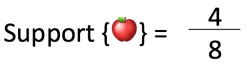

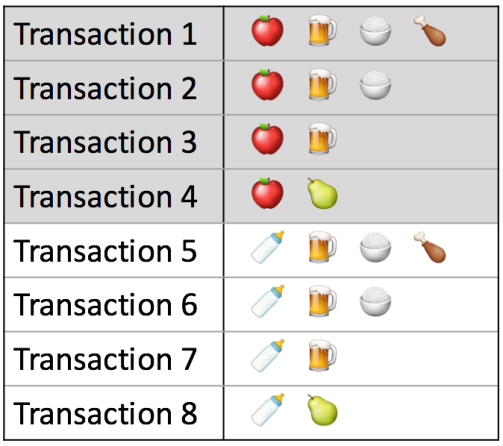

**2. Confidence:** The confidence of a rule measures how likely item \(Y\) is purchased when item \(X\) is purchased. It is defined as  
$$
\text{conf}(X \Rightarrow Y) = \frac{\text{supp}(X \cap Y)}{\text{supp}(X)} .
$$
Equivalently, confidence is the proportion of transactions that contain \(X\) in which \(Y\) also appears.

Using Table 1 as an example, the confidence of the rule $$(\{apple\} \Rightarrow \{beer\})$$ is \(3\) out of \(4\), or **75%**. This means that in **75%** of the transactions containing *apple*, *beer* also appears. Confidence can be interpreted as an estimate of the conditional probability $$(P(Y \mid X))$$, i.e., the probability of observing the right-hand side (RHS) given that the left-hand side (LHS) occurs.

In practice, association rules are typically required to satisfy **both** a minimum support threshold and a minimum confidence threshold.



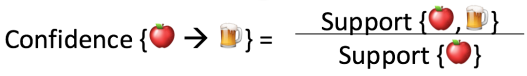

**3. Lift:** Lift is a popular measure for filtering or ranking association rules. It measures how likely item \(Y\) is purchased when item \(X\) is purchased, **while controlling for how common \(Y\) is overall**. Lift is defined as  
$$
\text{lift}(X \Rightarrow Y) = \frac{\text{supp}(X \cap Y)}{\text{supp}(X)\,\text{supp}(Y)} .
$$
Lift can be interpreted as how much the observed co-occurrence of \(X\) and \(Y\) deviates from what we would expect if \(X\) and \(Y\) were independent. A lift value **greater than 1** indicates a positive association (the items appear together more often than expected under independence).

Using Table 1 as an example, the lift of $$(\{apple\} \Rightarrow \{beer\})$$ is  
$$
\frac{3/8}{(4/8)\cdot(6/8)} = 1,
$$
which suggests **no association** between the items (they co-occur about as often as expected by chance). In general, a lift value **greater than 1** means \(Y\) is more likely to be purchased when \(X\) is purchased, while a value **less than 1** means \(Y\) is less likely to be purchased when \(X\) is purchased.


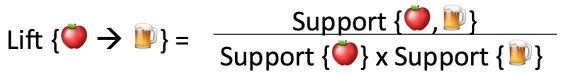


The figures above are borrowed from kdnuggets.com.

For more introductions, see:
- Complete Guide to Association Rules (Part 1): https://towardsdatascience.com/apriori-association-rule-mining-explanation-and-python-implementation-290b42afdfc6/



### **1.1 Groceries Case**
<a id="11-groceries-case"></a>
#### **1.1.1 Rule Identification**
<a id="111-rule-identification"></a>


The Groceries dataset contains 1 month (30 days) of real-world point-of-sale transaction data from a typical local grocery outlet. The data set contains 9835 transactions.

In [13]:
import requests
import warnings
warnings.resetwarnings()
warnings.filterwarnings(
    "ignore",
    category=DeprecationWarning,
    message=r"^.*utcnow\(\) is deprecated.*",
)

warnings.filterwarnings(
    "ignore",
    category=DeprecationWarning,
    message=r"^datetime\.datetime\.utcnow\(\) is deprecated.*",
)

warnings.filterwarnings(
    "ignore",
    category=DeprecationWarning,
    message=r"^datetime\.datetime\.utcnow\(\) is deprecated.*",
    module=r"jupyter_client(\..*)?$",
)
# If needed in Colab:
!pip -q install mlxtend
# !pip -q install networkx plotly scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from mlxtend.frequent_patterns import apriori, association_rules
import networkx as nx
import plotly.express as px
import plotly.graph_objects as go

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


/opt/anaconda3/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=82684) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.4.2 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.4.2 which is incompatible.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.17.1 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.4.2 which is incompatible.
pygam 0.12.0 requires scipy<1.17,>=1.11.1, but you have scipy 1.17.1 which is incompatible.


ImportError: cannot import name '_center' from 'numpy.core._multiarray_umath' (/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_multiarray_umath.cpython-312-darwin.so)

In [ ]:

groceries_url = "https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/groceries.csv"
text = requests.get(groceries_url).text

groceries_raw = pd.DataFrame({"items": [line.strip() for line in text.splitlines() if line.strip()]})

print("Number of transactions:", groceries_raw.shape[0])
print(groceries_raw.head().to_string(index=False))


In [ ]:
# ------------------------------------------------------------
# 1) Convert transactions to one-hot encoded format
# ------------------------------------------------------------
warnings.filterwarnings("ignore", category=DeprecationWarning)

transactions = groceries_raw["items"].str.split(",")

# Build one-hot dataframe: rows = transactions, cols = items
onehot = pd.get_dummies(transactions.apply(pd.Series).stack()).groupby(level=0).sum()
onehot = onehot.astype(bool)  # use boolean for apriori

print("One-hot shape:", onehot.shape)  # (#transactions, #unique items)

In [ ]:
# ------------------------------------------------------------
# 2) "summary(Groceries)"-style diagnostics
# - Most frequent items
# - Transaction length distribution
# ------------------------------------------------------------
item_freq = onehot.mean().sort_values(ascending=False)  # support per item
print("\nMost frequent items (top 10):")
print((item_freq.head(10) * 100).round(2).astype(str) + "%")

tx_lengths = onehot.sum(axis=1)
print("\nTransaction length distribution (describe):")
print(tx_lengths.describe())

In [ ]:
# ------------------------------------------------------------
# 3) Find very long transactions: size(Groceries) > 30
# ------------------------------------------------------------
long_tx = onehot[tx_lengths > 30]
print("\nNumber of transactions with > 30 items:", long_tx.shape[0])

if long_tx.shape[0] > 0:
    # Show the items in the first long transaction (similar to inspect())
    first_long = long_tx.iloc[0]
    items_in_first_long = list(first_long[first_long].index)
    print("\nItems in the first long transaction (>30 items):")
    print(items_in_first_long)


In [ ]:
# ------------------------------------------------------------
# 4) Item frequency plot: support > 0.10
# R: itemFrequencyPlot(Groceries, support=0.1, cex.names=0.8)
# ------------------------------------------------------------
support_threshold = 0.10
freq_over = item_freq[item_freq >= support_threshold].sort_values(ascending=True)

plt.figure(figsize=(8, 6))
plt.barh(freq_over.index, freq_over.values)
plt.xlabel("Support")
plt.title("Item Frequency Plot (Support ≥ 0.10)")
plt.tight_layout()
plt.show()


In [ ]:

# ------------------------------------------------------------
# 5) Apriori to find frequent itemsets and rules
# R: apriori(Groceries, sup=0.003, conf=0.5, target="rules")
# ------------------------------------------------------------
min_support = 0.003
frequent_itemsets = apriori(onehot, min_support=min_support, use_colnames=True)

print("\nFrequent itemsets found:", frequent_itemsets.shape[0])
print(frequent_itemsets.sort_values("support", ascending=False).head())

# Generate rules
rules = association_rules(
    frequent_itemsets,
    metric="confidence",
    min_threshold=0.5
)

# Add rule length (lhs + rhs), like size(basket_rules) in R
rules["rule_len"] = rules["antecedents"].apply(len) + rules["consequents"].apply(len)

# Sort similar to inspect(head(basket_rules))
rules_sorted = rules.sort_values(["support", "confidence", "lift"], ascending=False)

print("\nNumber of rules found:", rules.shape[0])
display(
    rules_sorted[["antecedents", "consequents", "support", "confidence", "lift", "rule_len"]].head(10)
)

In [ ]:
# ------------------------------------------------------------
# 6) Subset: rules with length > 4  (lhs + rhs > 4)
# R: subset(basket_rules, size(basket_rules) > 4)
# ------------------------------------------------------------
rules_len_gt4 = rules[rules["rule_len"] > 4].sort_values("lift", ascending=False)
print("\nRules with rule length > 4:", rules_len_gt4.shape[0])
display(rules_len_gt4[["antecedents", "consequents", "support", "confidence", "lift", "rule_len"]].head(20))


In [ ]:

# ------------------------------------------------------------
# 7) Subset: lift > 5
# R: subset(basket_rules, lift > 5)
# ------------------------------------------------------------
rules_lift_gt5 = rules[rules["lift"] > 5].sort_values("lift", ascending=False)
print("\nRules with lift > 5:", rules_lift_gt5.shape[0])
display(rules_lift_gt5[["antecedents", "consequents", "support", "confidence", "lift", "rule_len"]].head(20))


In [ ]:
# ------------------------------------------------------------
# 8) Subset: RHS contains "yogurt" and lift > 3.5
# R: subset(..., rhs %in% "yogurt" & lift > 3.5)
# ------------------------------------------------------------
def has_item_in_frozenset(fs, item):
    return item in fs

yogurt_rhs = rules[
    rules["consequents"].apply(lambda fs: has_item_in_frozenset(fs, "yogurt")) &
    (rules["lift"] > 3.5)
].sort_values("lift", ascending=False)

print("\nRules with RHS = yogurt and lift > 3.5:", yogurt_rhs.shape[0])
display(yogurt_rhs[["antecedents", "consequents", "support", "confidence", "lift", "rule_len"]])


In [ ]:
# ------------------------------------------------------------
# 9) Subset: LHS contains "meat" and lift > 2
# R: subset(..., lhs %in% "meat" & lift > 2)
# ------------------------------------------------------------
meat_lhs = rules[
    rules["antecedents"].apply(lambda fs: has_item_in_frozenset(fs, "meat")) &
    (rules["lift"] > 2)
].sort_values("lift", ascending=False)

print("\nRules with LHS contains meat and lift > 2:", meat_lhs.shape[0])
display(meat_lhs[["antecedents", "consequents", "support", "confidence", "lift", "rule_len"]])


### **1.1.2 Rule Visualization**
<a id="112-rule-visualization"></a>

In [ ]:
# ------------------------------------------------------------
# 10) Basic visualization (Python analogue to arulesViz plots)
# - Scatter: support vs confidence, colored by lift (via point size)
# ------------------------------------------------------------
plt.figure(figsize=(7, 5))
plt.scatter(rules["support"], rules["confidence"], s=20 * rules["lift"], alpha=0.5)
plt.xlabel("Support")
plt.ylabel("Confidence")
plt.title("Association Rules: Support vs Confidence (size ~ lift)")
plt.tight_layout()
plt.show()

In [ ]:
# ------------------------------------------------------------
# Helper: convert frozenset to readable strings
# ------------------------------------------------------------
def fs_to_str(fs):
    return ", ".join(sorted(list(fs)))

rules_viz = rules.copy()
rules_viz["lhs"] = rules_viz["antecedents"].apply(fs_to_str)
rules_viz["rhs"] = rules_viz["consequents"].apply(fs_to_str)

# ------------------------------------------------------------
# (1) Scatter plot (support vs confidence), color = lift
# R: plot(basket_rules)  (with jitter)
# ------------------------------------------------------------
# optional jitter to reduce overplotting (similar spirit to arulesViz)
rng = np.random.default_rng(123)
jitter_scale = 0.0003
rules_viz["support_j"] = rules_viz["support"] + rng.normal(0, jitter_scale, size=len(rules_viz))
rules_viz["confidence_j"] = rules_viz["confidence"] + rng.normal(0, 0.003, size=len(rules_viz))

In [ ]:
# ------------------------------------------------------------
# (2) Interactive inspection table (simple analogue to interactive=TRUE)
# R: plot(basket_rules, interactive=TRUE)
# ------------------------------------------------------------
# In Colab, a searchable display is easiest via a DataFrame
display(
    rules_viz[["lhs", "rhs", "support", "confidence", "lift"]]
    .sort_values(["lift", "confidence"], ascending=False)
    .head(30)
)


In [ ]:
# ------------------------------------------------------------
# (3) Graph visualization for top-10 rules by lift
# R: plot(head(sort(basket_rules, by="lift"), 10), method="graph")
# ------------------------------------------------------------
top10 = rules_viz.sort_values("lift", ascending=False).head(10)

G = nx.DiGraph()
for _, r in top10.iterrows():
    lhs_items = list(r["antecedents"])
    rhs_items = list(r["consequents"])

    # connect each lhs item -> each rhs item
    for a in lhs_items:
        for b in rhs_items:
            G.add_edge(
                a, b,
                weight=float(r["lift"]),
                support=float(r["support"]),
                confidence=float(r["confidence"])
            )

# layout
pos = nx.spring_layout(G, seed=123)

plt.figure(figsize=(10, 7))
nx.draw_networkx_nodes(G, pos, node_size=900)
nx.draw_networkx_labels(G, pos, font_size=9)

# edge widths based on lift
weights = np.array([G[u][v]["weight"] for u, v in G.edges()])
w_scaled = 1 + 4 * (weights - weights.min()) / (weights.max() - weights.min() + 1e-12)

nx.draw_networkx_edges(G, pos, width=w_scaled, arrows=True, arrowsize=18)

plt.title("Top-10 Rules by Lift (Item Graph)")
plt.axis("off")
plt.show()

In [ ]:
# (4) Grouped / clustered view of rules (analogue to method="grouped")
# R: plot(basket_rules, method="grouped")
#
# We cluster rules using (support, confidence, lift) and then plot them.
# ------------------------------------------------------------
X_feat = rules_viz[["support", "confidence", "lift"]].to_numpy()
X_feat = StandardScaler().fit_transform(X_feat)

k = 4  # choose a small number of clusters for interpretability
km = KMeans(n_clusters=k, random_state=123, n_init=10)
rules_viz["cluster"] = km.fit_predict(X_feat).astype(str)

cluster_summary = (
    rules_viz.groupby("cluster")[["support", "confidence", "lift"]]
    .agg(["count", "mean", "median"])
)
display(cluster_summary)


# **2. Case Starter Code**
<a id="2-case-starter-code"></a>
Use the code below to load the Cincinnati Zoo transaction data for association rules mining.

Note:
- In the zoo data, rule support is relatively low; the maximum support is typically no more than ~3%.


In [ ]:
# If needed, install mlxtend (common for association rules in Python)
# !pip -q install mlxtend

import pandas as pd
import numpy as np

# 1) Load data
url = "https://yanyudm.github.io/Data-Mining-R/data/food_4_association.csv"
trans_food = pd.read_csv(url)

# 2) Drop the first column (matches TransFood <- TransFood[, -1])
trans_food = trans_food.iloc[:, 1:]

# 3) Find entries not equal to 0 or 1 and set them to 1
arr = trans_food.to_numpy()
others_mask = (arr != 0) & (arr != 1)
arr[others_mask] = 1

# Ensure integer 0/1
arr = arr.astype(int)
trans_food = pd.DataFrame(arr, columns=trans_food.columns)

# 4) Coerce to a "transactions"-like format (list of itemsets)
#    Each row becomes a list of items whose value is 1
transactions = [
    trans_food.columns[row.astype(bool)].tolist()
    for row in trans_food.to_numpy()
]

# Preview
print("Shape:", trans_food.shape)
print("First 3 transactions:", transactions[:3])


Sparsity and “items per basket” distribution

In [ ]:

basket_sizes = trans_food.sum(axis=1)              # items per transaction
item_support = trans_food.mean(axis=0)             # support of each item (fraction of baskets)

print(f"Transactions: {trans_food.shape[0]}")
print(f"Items: {trans_food.shape[1]}")
print(f"Avg items/basket: {basket_sizes.mean():.4f}")

plt.figure()
plt.hist(basket_sizes, bins=30)
plt.xlabel("Items per transaction")
plt.ylabel("Count")
plt.title("Basket Size Distribution")
plt.show()


Top-N most frequent items (support)

In [ ]:
top_n = 20
top_items = item_support.sort_values(ascending=False).head(top_n)

plt.figure()
top_items.plot(kind="bar")
plt.ylabel("Support")
plt.title(f"Top {top_n} Item Supports")
plt.show()

top_items.to_frame("support").round(4)


Compute pair counts (fast, vectorized)

In [ ]:
X = trans_food.to_numpy(dtype=int)
pair_counts = X.T @ X  # (items x items), counts of co-occurrence
np.fill_diagonal(pair_counts, 0)

pair_df = pd.DataFrame(pair_counts, index=trans_food.columns, columns=trans_food.columns)

# Top 15 co-occurring pairs
pairs = (
    pair_df.where(np.triu(np.ones(pair_df.shape), k=1).astype(bool))
          .stack()
          .sort_values(ascending=False)
          .head(15)
)

pairs.rename("co_occurrence_count").to_frame()


Network graph of item co-occurrence

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Build a graph from top co-occurring pairs
G = nx.Graph()

# Choose a threshold so the graph isn’t too dense
threshold = 200  # adjust up/down depending on density

for i in range(pair_df.shape[0]):
    for j in range(i+1, pair_df.shape[1]):
        w = pair_counts[i, j]
        if w >= threshold:
            G.add_edge(trans_food.columns[i], trans_food.columns[j], weight=w)

plt.figure(figsize=(10, 40))
pos = nx.spring_layout(G, seed=42)

# edge widths proportional to weight (scaled)
weights = np.array([G[u][v]["weight"] for u, v in G.edges()])
if len(weights) > 0:
    widths = 1 + 4 * (weights - weights.min()) / (weights.max() - weights.min() + 1e-9)
else:
    widths = 1

nx.draw_networkx_nodes(G, pos, node_size=600)
nx.draw_networkx_labels(G, pos, font_size=9)
nx.draw_networkx_edges(G, pos, width=widths, alpha=0.6)
plt.title(f"Item Co-occurrence Network (threshold ≥ {threshold})")
plt.axis("off")
plt.show()

print("Nodes:", G.number_of_nodes(), "Edges:", G.number_of_edges())


In [ ]:
%%shell
jupyter nbconvert --to html ///content/11_Association_Rules.ipynb